In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
from astroML.time_series import ACF_scargle,ACF_EK

In [2]:
tic = 29984014

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:109: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


[Text(0, 0.5, 'Normalized PDCSAP\\_FLUX [$e^-/s$]'),
 Text(0.5, 0, 'BJD - 2457000 [$d$]')]

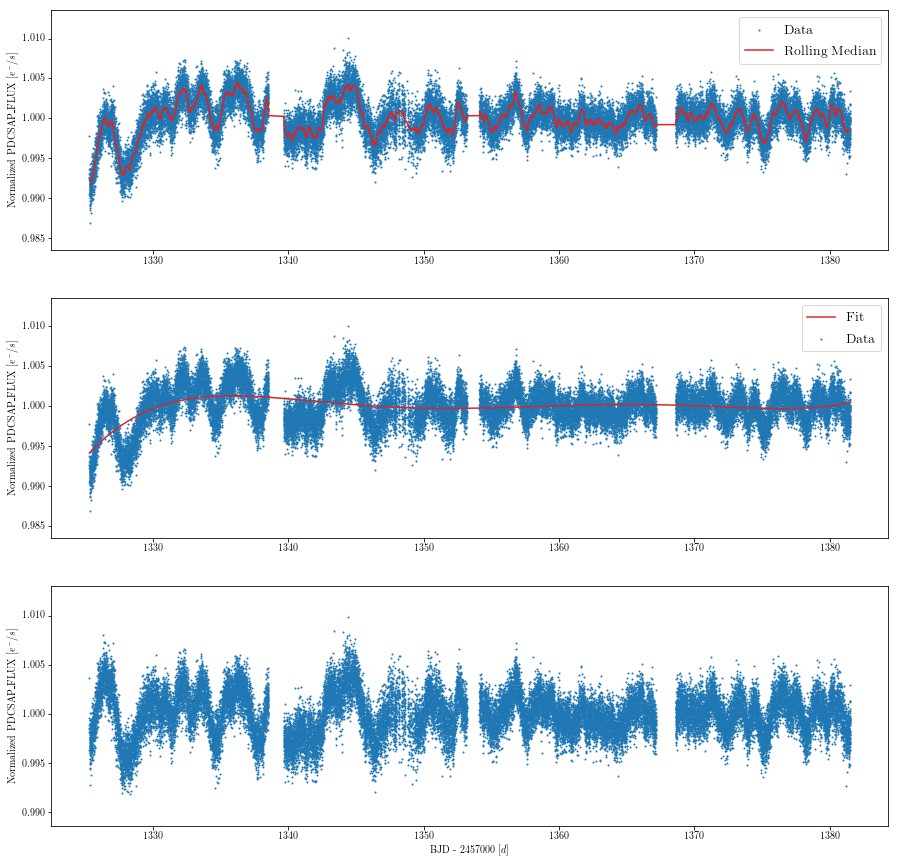

In [3]:
# we need to normalize the light curve here.
fig, ax = plt.subplots(3, figsize=(15,15))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
ax[0].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'],c='C3',label='Rolling Median')
ax[0].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

lc, p = polynorm(lc, deg=7)

vals = np.polyval(p, lc['Time'])
ax[1].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[1].plot(lc['Time'],vals,c='C3',label='Fit')
ax[1].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
ax[1].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})


ax[2].scatter(lc['Time'],lc['NormFlux'],s=1)
ax[2].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')

In [4]:
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']

In [5]:
#Defining functions

def phi_1(t,omega,tau):
    """
    Returns 1 for all times; sets the coarse detail in the wavelet transform. Note that 
    the parameters omega and tau have no use here; we only include them to loop over
    the basis functions.
    
    Parameters
    ----------
    t : array-like
        times
    omega : float
        angular frequency in radians per unit time. 
    tau : float
        time shift in same units as t
        
    Returns
    -------
    out : array-like
        array of 1s of length t
    
    """
    return np.ones(len(t))

def phi_2(t,omega,tau):
    """
    Second basis function, cos(omega(t-tau))
    
    Parameters
    ----------
    t : array-like
        times
    omega : float
        angular frequency in radians per unit time. 
    tau : float
        time shift in same units as t
        
    Returns
    -------
    out : array-like
        value of phi_2
    
    """
    return np.cos(omega*(t-tau))

def phi_3(t,omega,tau):
    """
    Third basis function, sin(omega(t-tau))
    
    Parameters
    ----------
    t : array-like
        times of observations
    omega : float
        angular frequency in radians per unit time. 
    tau : float
        time shift in same units as t
        
    Returns
    -------
    out : array-like
        value of phi_3
    
    """
    return np.sin(omega*(t-tau))

#Let's put these in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
c = 0.0125

def w_alpha(t,omega,tau,c): 
    """
    Weighting function for each point at a given omega and tau; (5-3) in Foster (1996)
    
    Parameters
    ----------
    t : array-like
        times of observations
    omega : float
        angular frequency in radians per unit time. 
    tau : float
        time shift in same units as t
    c : float
        Decay constant of the Gaussian envelope for the wavelet
        
    Returns
    -------
    weights : array-like
        Statistical weights of data points
    
    """
    return np.exp(-c*np.power(omega*(t - tau),2.0))

def N_eff(ws):
    """
    Effective number of points contributing to the transform; (5-4) in Foster (1996)
    
    Parameters
    ----------
    ws : array-like
        weights of observations, already calculated
        
    Returns
    -------
    Neff : float
        Effective number of data points
    
    """
    
    return np.power(np.sum(ws),2.0)/np.sum(np.power(ws,2.0))

def function_inner_product(func1,func2,ws):
    """
    Define the inner product of two functions; (4-2) in Foster (1996)
    
    Parameters
    ----------
    func1 : array-like
        Values of f at times corresponding to the weights
    func2 : array-like
        Values of g at times corresponding to the weights
    ws : array-like
        weights of observations, already calculated
        
    Returns
    -------
    inner_product : float
        Inner product of func1 and func2
    
    """
    num = np.sum(ws*func1*func2)
    den = np.sum(ws)
    return num/den

def S_matrix(func_vals,ws):
    """
    Define the S-matrix; (4-2) in Foster (1996)
    
    Takes the values of the functions already evaluated at the times of observations
    
    Parameters
    ----------
    func_vals : array-like
        Array of values of basis functions at times corresponding to the weights
        Should have shape (number of basis functions,len(ws))
    ws : array-like
        weights of observations, already calculated
        
    Returns
    -------
    S : `numpy.matrix`
        S-matrix; size len(func_vals)xlen(func_vals)
    
    """
    S = np.array([[function_inner_product(f1,f2,ws) for f1 in func_vals] for f2 in func_vals])
    return np.matrix(S)

def inner_product_vector(func_vals,ws,y):
    """
    Generates a column vector consisting of the inner products between the basis
    functions and the observed data
    
    Parameters
    ----------
    func_vals : array-like
        Array of values of basis functions at times corresponding to the weights
        Should have shape (number of basis functions,len(ws))
    ws : array-like
        weights of observations, already calculated
    y : array-like
        Observed data
        
    Returns
    -------
    phi_y : `numpy.array`
        Column vector where phi_y_i = phi_i * y
    
    """
    return np.array([[function_inner_product(func,y,ws) for func in func_vals]]).T

def coeffs(func_vals,ws,y):
    """
    Calculate the coefficients of each $\phi$. Adapted from (4-4) in Foster (1996)
    
    Parameters
    ----------
    func_vals : array-like
        Array of values of basis functions at times corresponding to the weights
        Should have shape (number of basis functions,len(ws))
    ws : array-like
        Weights of observations, already calculated
    y : array-like
        Observed data
        
    Returns
    -------
    coeffs : `numpy.array`
        Contains coefficients for each basis function
    
    """
    S_m = S_matrix(func_vals,ws)
    phi_y = inner_product_vector(func_vals,ws,y)
    return np.linalg.solve(S_m,phi_y).T

def V_x(f1_vals,ws,y):
    """
    Calculate the weighted variation of the data. Adapted from (5-9) in Foster (1996)
    
    Parameters
    ----------
    f1_vals : array-like
        Array of values of the first basis function; should be equivalent to
        `numpy.ones(len(y))`
    ws : array-like
        Weights of observations, already calculated
    y : array-like
        Observed data
        
    Returns
    -------
    vx : float
        Weighted variation of the data
    
    """
    return function_inner_product(y,y,ws) - np.power(function_inner_product(f1_vals,y,ws),2.0)

def y_fit(func_vals,ws,y):
    """
    Calculate the value of the model. 
    
    Parameters
    ----------
    func_vals : array-like
        Array of values of basis functions at times corresponding to the weights
        Should have shape (number of basis functions,len(ws))
    ws : array-like
        Weights of observations, already calculated
    y : array-like
        Observed data
        
    Returns
    -------
    y_f : array-like
        Values of the fit model
    y_a : `numpy.array`
        The coefficients returned by `coeffs`
    
    """
    y_a = coeffs(func_vals,ws,y)
    return y_a.dot(func_vals),y_a

def V_y(func_vals,f1_vals,ws,y):
    """
    Calculate the weighted variation of the model. Adapted from (5-10) in Foster (1996) 
    
    Parameters
    ----------
    func_vals : array-like
        Array of values of basis functions at times corresponding to the weights
        Should have shape (number of basis functions,len(ws))
    f1_vals : array-like
        Array of values of the first basis function; should be equivalent to
        `numpy.ones(len(y))`
    ws : array-like
        Weights of observations, already calculated
    y : array-like
        Observed data
        
    Returns
    -------
    vy : float
        Weighted variation of the model
    y_a :float
        Coefficients from `coeffs`
    
    """
    y_f,y_a = y_fit(func_vals,ws,y)
    return function_inner_product(y_f,y_f,ws) - np.power(function_inner_product(f1_vals,y_f,ws),2.0),y_a

def WWZ(func_list,f1,y,t,omega,tau,c=0.0125):
    """
    Calculate the Weighted Wavelet Transform of the data `y`, measured at times `t`,
    evaluated at a wavelet scale $\omega$ and shift $\tau$, for a decay factor of the
    Gaussian envelope `c`. Adapted from (5-11) in Foster (1996) 
    
    Parameters
    ----------
    func_list : array-like
        Array or list containing the basis functions, not yet evaluated
    f1 : array-like
        First basis function. Should be equivalent to `lambda x: numpy.ones(len(x))`
    y : array-like
        Observed data
    t : array-like
        Times of observations
    omega : float
        Scale of wavelet; corresponds to an angular frequency
    tau : float
        Shift of wavelet; corresponds to a time
    c : float
        Decay rate of Gaussian envelope of wavelet. Default 0.0125
        
    Returns
    -------
    WWZ : float
        WWZ of the data at the given frequency/time.
    WWA : float
        Corresponding amplitude of the signal at the given frequency/time
    
    """
    
    ws = w_alpha(t,omega,tau,c)
    Neff = N_eff(ws)
    
    func_vals = np.array([f(t,omega,tau) for f in func_list])
    
    f1_vals = f1(t,omega,tau)
    
    Vx = V_x(f1_vals,ws,y)
    Vy,y_a = V_y(func_vals,f1_vals,ws,y)
    
    y_a_rows = y_a[0]
    
    return ((Neff - 3.0) * Vy)/(2.0 * (Vx - Vy)),np.sqrt(np.power(y_a_rows[1],2.0)+np.power(y_a_rows[2],2.0))

In [12]:
#Let's try it!
y = flux.values
t = time.values
omega_start = -5 #log2(1/32)
omega_end = 4.5 #log2(16) 
omegas = np.logspace(omega_start,omega_end,50,base=2)
taus = np.linspace(np.min(t),np.max(t),100)
transform = np.array([[WWZ(func_list,f1,y,t,omega,tau) for omega in omegas] for tau in taus])
wwz = transform[:,:,0]
wwa = transform[:,:,1]

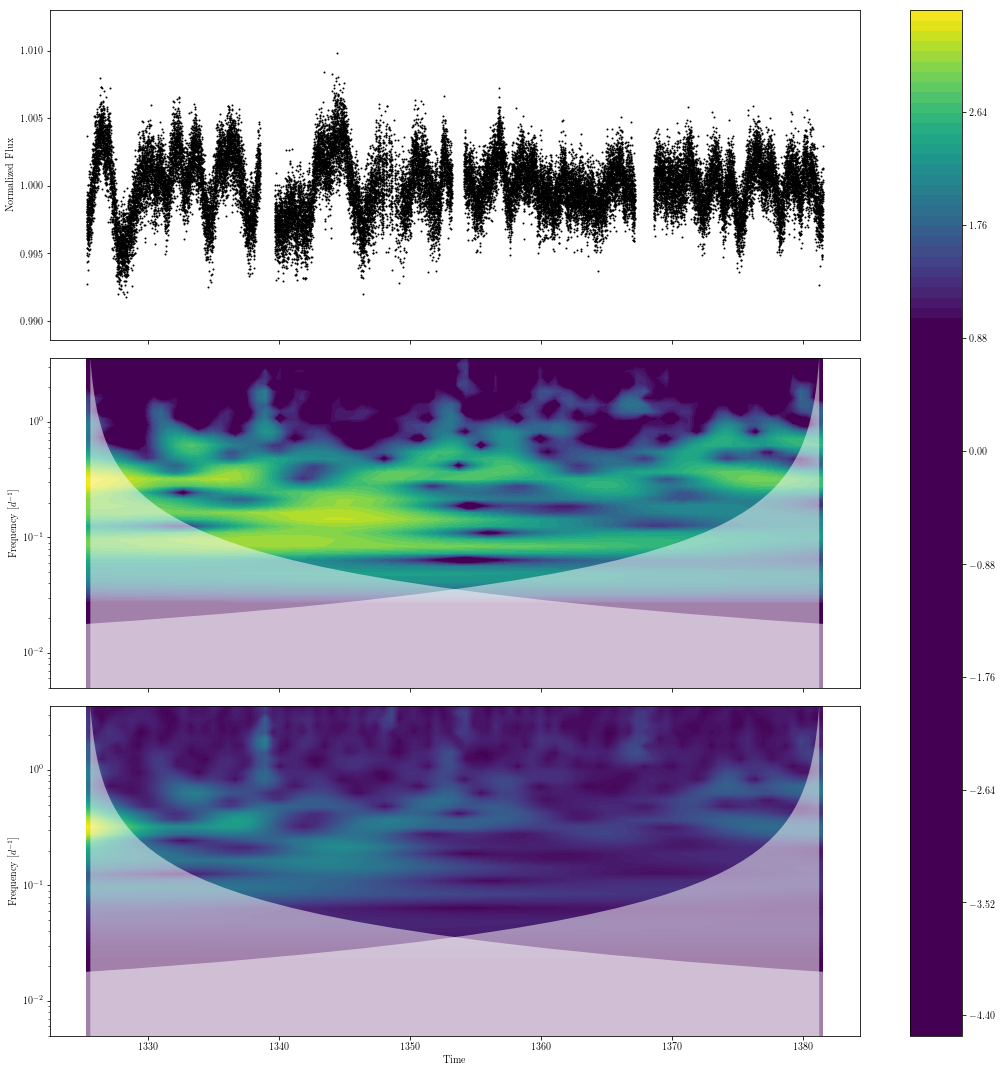

In [14]:
fig,ax = plt.subplots(3,figsize=(15,15),sharex=True)
ax[0].scatter(time,flux,s=1,c='k')
xl = ax[0].get_xlim()
mesh = ax[1].contourf(taus,omegas/2.0/np.pi,np.log10(wwz).T,levels=100,vmin=1)
ax[2].contourf(taus,omegas/2.0/np.pi,wwa.T,levels=100)
yl = ax[1].get_ylim()
ax[1].fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[1].fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[1].set(ylim=yl,xlim=xl,yscale='log',ylabel='Frequency [$d^{-1}$]')
yl = ax[2].get_ylim()
ax[2].fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[2].fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[2].set(ylim=yl,xlim=xl,yscale='log',xlabel='Time',ylabel='Frequency [$d^{-1}$]')
ax[0].set(ylabel='Normalized Flux',xlim=xl)
fig.tight_layout()
plt.colorbar(mappable=mesh,ax=ax)

In [4]:
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)

f_Ny = 323.83746567083887, f_R = 0.017787891882718898
10
20
30
40
50
60
Found 64 frequencies
33 unique frequencies


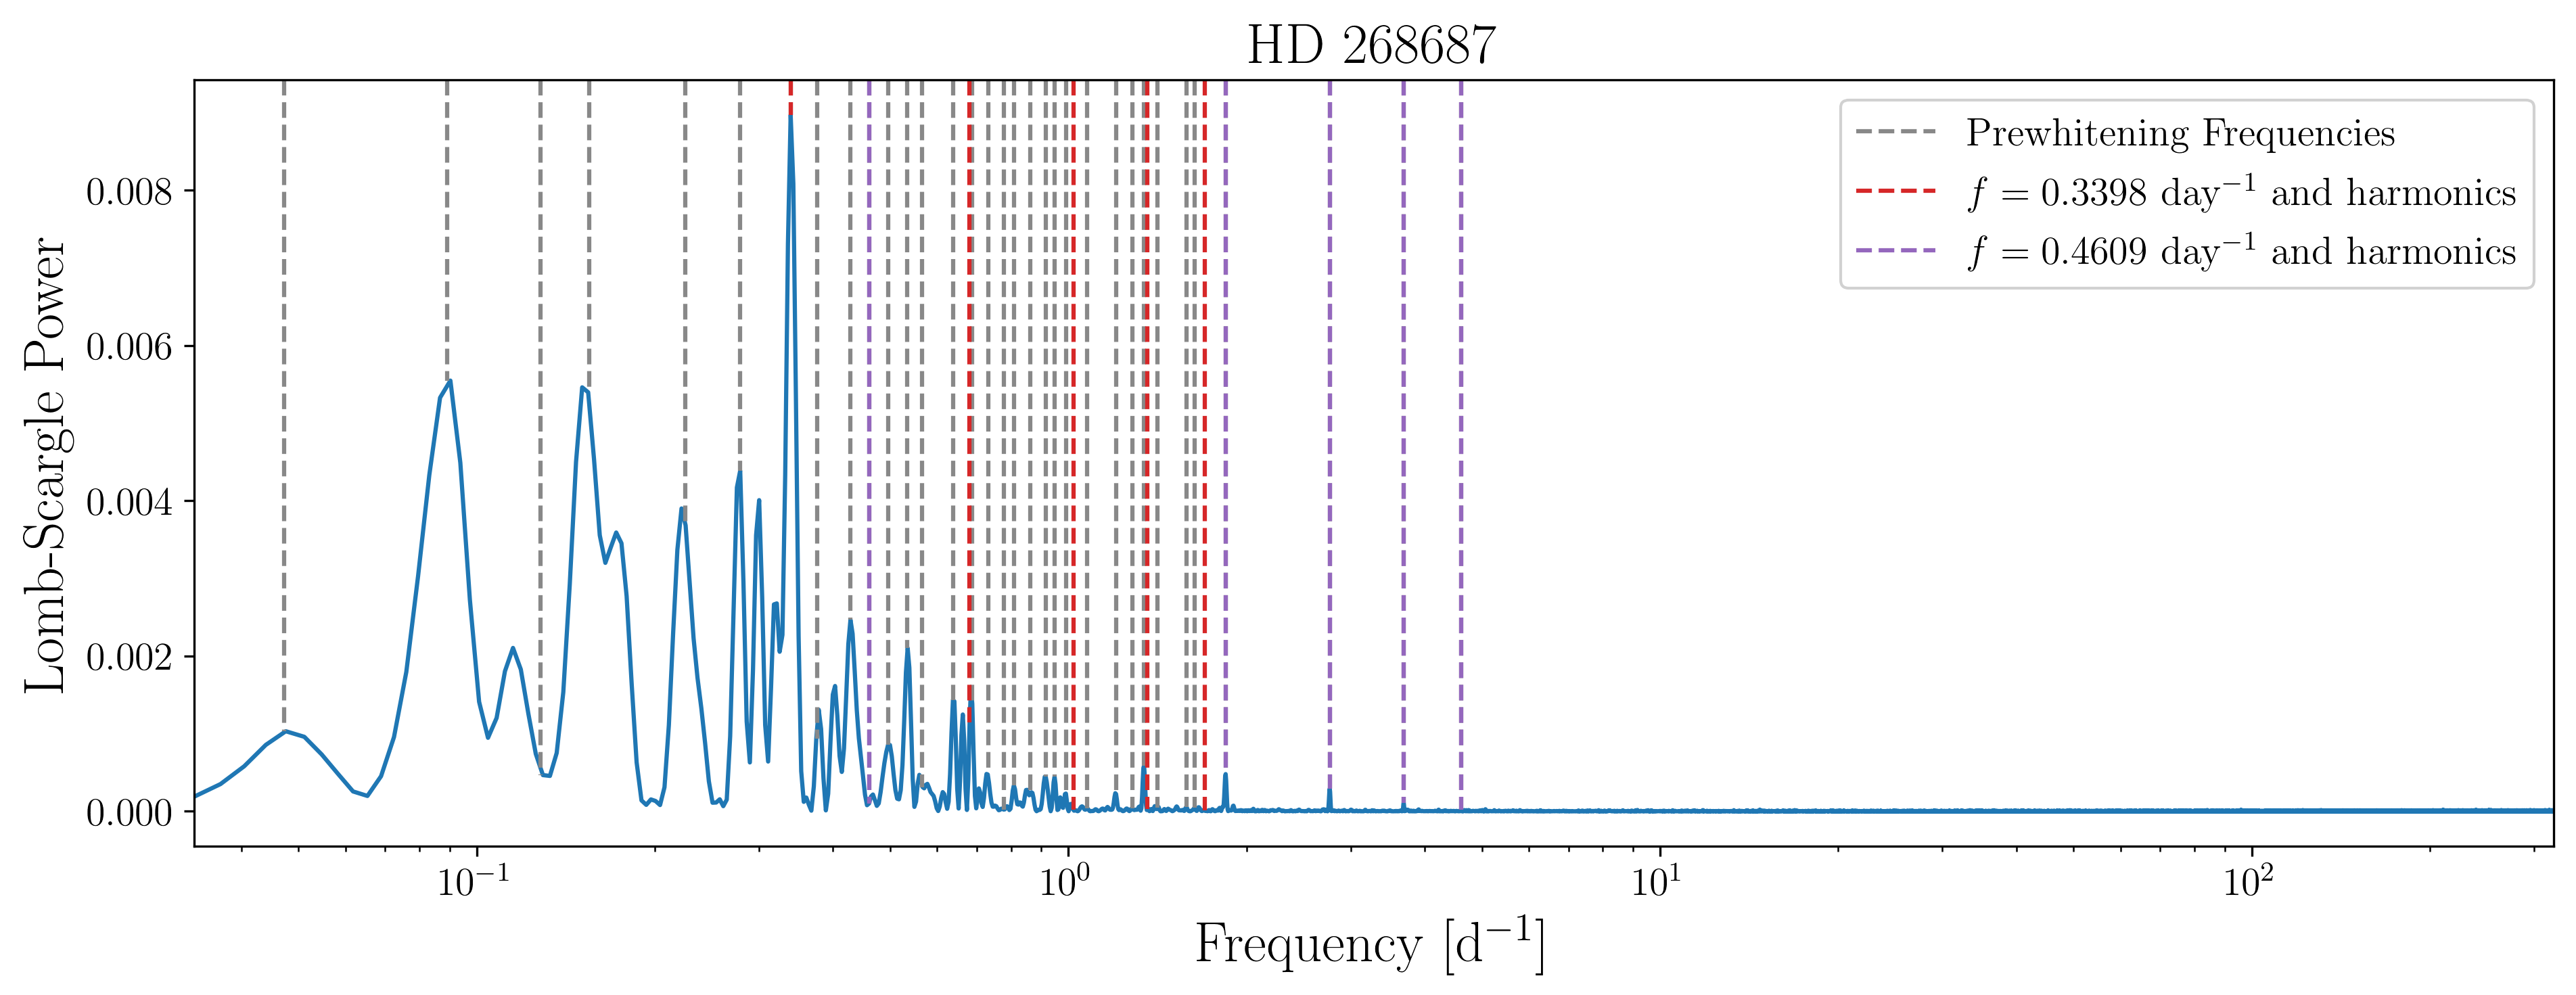

In [5]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
 
dom = 0.3398155918857977
plt.plot([dom,dom],[ylim[1],power[np.argmin(np.abs(freq-dom))]],c='C3',ls='--',label='$f=0.3398$ day$^{-1}$ and harmonics')
for i in range(2,6):
    plt.plot([i*dom,i*dom],[ylim[1],power[np.argmin(np.abs(freq-i*dom))]],c='C3',ls='--')
    
fund = harmonics[0,6]
harms = harmonics[1,6:]
plt.plot([fund,fund],[ylim[1],power[np.argmin(np.abs(freq-fund))]],c='C4',ls='--',label='$f=0.4609$ day$^{-1}$ and harmonics')
for h in harms:
    plt.plot([h,h],[ylim[1],power[np.argmin(np.abs(freq-h))]],c='C4',ls='--')
   
    
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)    
plt.savefig('../plots/HD268687_periodogram.pdf')

/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:73: RuntimeWarning: invalid value encountered in greater
  if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):


[0.06181388 0.1909334  0.12508592 0.25312258 0.58976342]


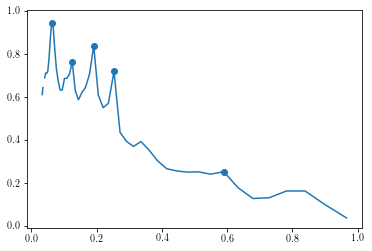

In [6]:
C_EK, C_EK_err, bins = ACF_EK(freq[freq<=1], power[freq<=1], 0.001*power[freq<=1], bins=np.logspace(-1.5, 0, 50))
f_EK = 0.5 * (bins[1:] + bins[:-1])
plt.plot(f_EK,C_EK)
f,p = peak_finder(f_EK,C_EK,10,width=3)
plt.scatter(f,p)
print(f)

In [7]:
harmonic_search(good_fs)

array([[ 0.42764474,  0.12802564,  0.12802564,  0.04723986,  0.04723986,
         1.84286938,  0.46094861,  0.46094861,  0.46094861,  0.46094861],
       [ 1.28252486,  0.63934778,  1.28252486,  0.37663919,  0.42764474,
         3.68650176,  1.84286938,  2.76492751,  3.68650176,  4.60899785],
       [ 3.        ,  5.        , 10.        ,  8.        ,  9.        ,
         2.        ,  4.        ,  6.        ,  8.        , 10.        ]])

In [8]:
combo_search(good_fs)

array([[0.33981559, 0.33981559, 0.08920241, 0.42764474, 0.42764474,
        0.12802564, 0.12802564, 0.63934778, 0.63934778, 1.84286938],
       [0.86314365, 1.07507415, 0.68791268, 1.20371478, 1.4145172 ,
        0.86314365, 1.07507415, 1.20371478, 0.99151843, 2.76492751],
       [1.20371478, 1.4145172 , 0.77723411, 1.63275628, 1.84286938,
        0.99151843, 1.20371478, 1.84286938, 1.63275628, 4.60899785]])

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


Text(0.5, 1.0, 'HD 268687')

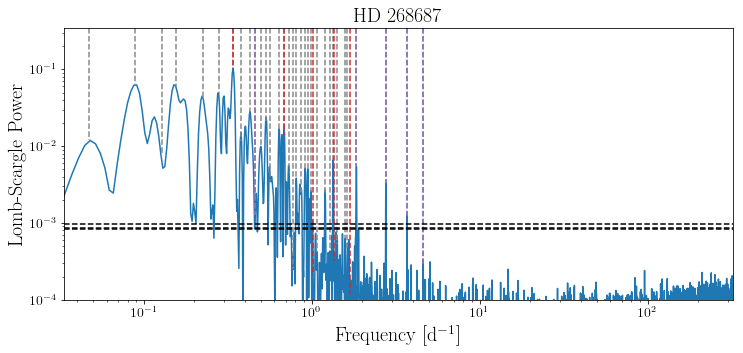

In [25]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
lc = polynorm(lc, deg=7)[0]
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
 
dom = 0.3398155918857977
plt.plot([dom,dom],[ylim[1],power[np.argmin(np.abs(freq-dom))]],c='C3',ls='--',label='$f=0.3398$ day$^{-1}$ and harmonics')
for i in range(2,6):
    plt.plot([i*dom,i*dom],[ylim[1],power[np.argmin(np.abs(freq-i*dom))]],c='C3',ls='--')
    
fund = harmonics[0,6]
harms = harmonics[1,6:]
plt.plot([fund,fund],[ylim[1],power[np.argmin(np.abs(freq-fund))]],c='C4',ls='--',label='$f=0.4609$ day$^{-1}$ and harmonics')
for h in harms:
    plt.plot([h,h],[ylim[1],power[np.argmin(np.abs(freq-h))]],c='C4',ls='--')
   
    
ax.set(ylim=(1e-4,ylim[1]))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20) 

In [22]:
lc['Time']

TypeError: tuple indices must be integers or slices, not str